In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\DLS-git")
onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
from code_comparison.solps_pp import *

from DLScommonTools import *
from Morph import *
from Postprocess import *
from copy import deepcopy

%matplotlib inline
set_matplotlib_defaults()

%load_ext autoreload
%autoreload 2



st40_phys_viewer can not be loaded from outside Tokamak Energy!



# Read balance file

In [3]:
balance_path = r"C:\Users\mikek\OneDrive\Project\DLS\from_stuart\2023-07-11 - SPR45 balance file\balance.nc"
eqb = dict()
eqb["SPR45"] = dict()

for side in ["il", "ol", "iu", "ou"]: # Inner lower, outer lower.
    eqb["SPR45"][side] = unpackConfigurationMK(File = balance_path, Type = side, sepadd=0, resolution = 200)
    
    keys = list(eqb["SPR45"][side].keys())
    for key in keys:
        
        if key not in ["Bpol", "Btot", "Xpoint", "Spol", "S", "R", "Z"]:
            eqb["SPR45"][side].pop(key, None)
        
file_write(eqb, "equilibrium.pkl")

In [4]:
eqb = file_read("equilibrium.pkl")
data = eqb["SPR45"] # Pick design to use for study

# Read and write simulation results

In [152]:
file_write(profiles, "2024-01-18 - BxBt and L scans - profiles.pkl")
file_write(stores, "2024-01-18 - BxBt and L scans - stores.pkl")

In [ ]:
stores = file_read("2024-01-18 - BxBt and L scans - stores.pkl")
profiles = file_read("2024-01-18 - BxBt and L scans - profiles.pkl")

# Setup and run DLS

In [5]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, # Upstream density (if constant)
    "nu0" : 1e20, # Upstream density (if constant)
    "cz0" : 0.02, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbachAr, # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
}

In [6]:
%matplotlib inline
plt.close("all")

# Test new scaling tools

0.4999999999999999


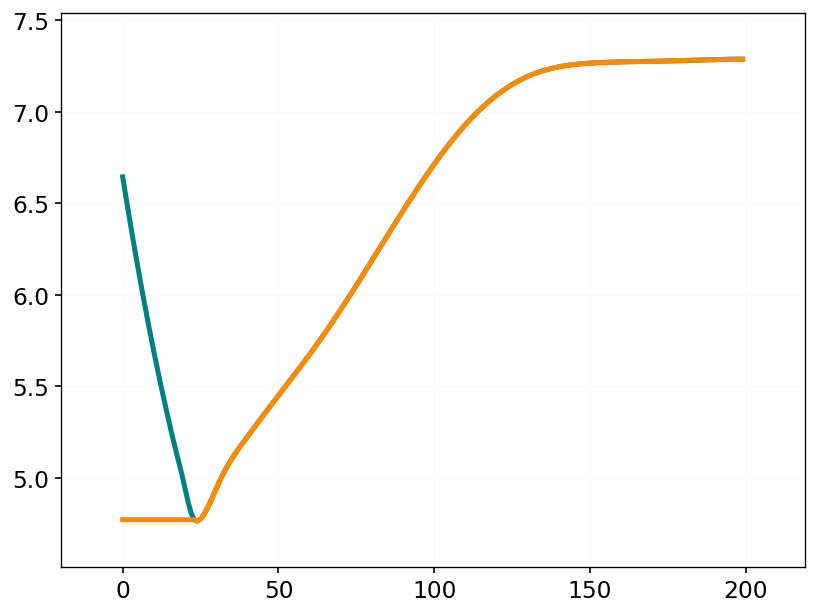

In [170]:
d = eqb["SPR45"]["il"]
base = Profile(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])
self = base.copy()
BxBt = 1
self.scale_BxBt(BxBt = 0.5)
print(self.get_total_flux_expansion())
        
fig, ax = plt.subplots()
ax.plot(Btot)
ax.plot(Btot_new)
# fig, ax = plt.subplots()
# ax.plot(base.Spol, base.Btot)
# ax.plot(new.Spol, new.Btot, marker = "o")


# Set up profiles

In [146]:
pstore = {}

In [147]:
d = eqb["SPR45"]["il"]
base = Profile(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])
new = base.copy()

BxBt_base = base.get_total_flux_expansion()
list_BxBt = np.concatenate([np.linspace(BxBt_base/2, BxBt_base, 5), np.linspace(BxBt_base, BxBt_base*2, 5)])
list_BxBt = np.unique(list_BxBt)

profiles = {}
for BxBt in list_BxBt:
    profiles[BxBt] = base.copy()
    profiles[BxBt].scale_BxBt(BxBt = BxBt, verbose = False)
    
pstore["inner_BxBt"] = profiles.copy()

d = eqb["SPR45"]["il"]
base = Profile(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])
new = base.copy()

Lc_base = base.get_connection_length()
list_Lc = np.concatenate([np.linspace(Lc_base/1.5, Lc_base, 5), np.linspace(Lc_base, Lc_base*1.5, 5)])
list_Lc = np.unique(list_Lc)

profiles = {}
for Lc in list_Lc:
    profiles[Lc] = base.copy()
    profiles[Lc].scale_Lc(Lc = Lc, verbose = False)
    
pstore["inner_Lc"] = profiles.copy()


d = eqb["SPR45"]["ol"]
base = Profile(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])
new = base.copy()

BxBt_base = base.get_total_flux_expansion()
list_BxBt = np.concatenate([np.linspace(BxBt_base/2, BxBt_base, 5), np.linspace(BxBt_base, BxBt_base*2, 5)])
list_BxBt = np.unique(list_BxBt)

profiles = {}
for BxBt in list_BxBt:
    profiles[BxBt] = base.copy()
    profiles[BxBt].scale_BxBt(BxBt = BxBt, verbose = False)
    
pstore["outer_BxBt"] = profiles.copy()


d = eqb["SPR45"]["ol"]
base = Profile(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])
new = base.copy()

Lc_base = base.get_connection_length()
list_Lc = np.concatenate([np.linspace(Lc_base/1.5, Lc_base, 5), np.linspace(Lc_base, Lc_base*1.5, 5)])
list_Lc = np.unique(list_Lc)

profiles = {}
for Lc in list_Lc:
    profiles[Lc] = base.copy()
    profiles[Lc].scale_Lc(Lc = Lc, verbose = False)
    
pstore["outer_Lc"] = profiles.copy()


C:\Users\mikek\AppData\Local\Temp\ipykernel_7520\227966755.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Spectral_r', 9)


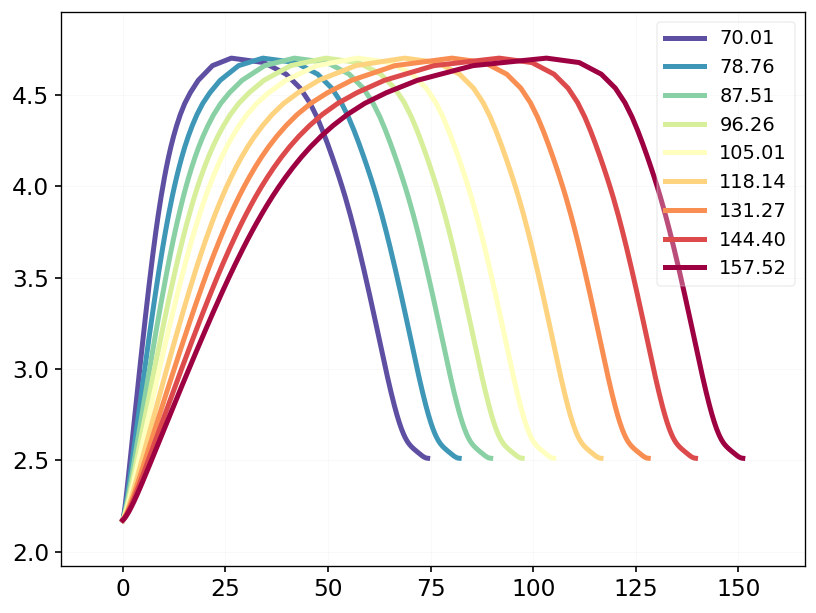

In [11]:
fig, ax = plt.subplots()

cmap = mpl.cm.get_cmap('Spectral_r', 9)
colors = [cmap(x) for x in np.linspace(0,1, len(profiles))]

name = "outer_Lc"
for i, id in enumerate(pstore[name]):
    p = pstore[name][id]
    ax.plot(p.S, p.Btot, color = colors[i], label = f"{id:.2f}")
    # print(id, p.get_connection_length())
    
ax.legend(fontsize = "small")

# Scans

In [12]:
stores = {}

# Inner Lc scan

C:\Users\mikek\AppData\Local\Temp\ipykernel_7520\1966015621.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Spectral_r', 9)


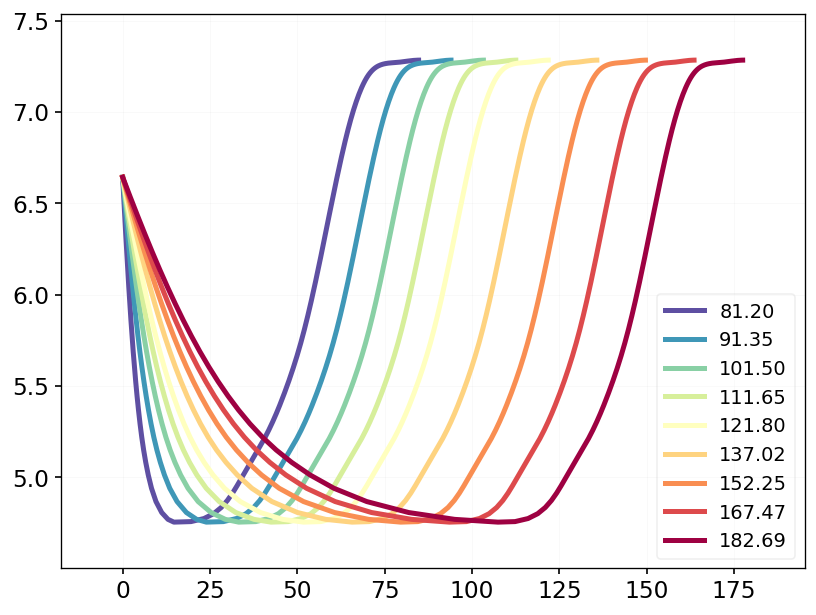

In [192]:
fig, ax = plt.subplots()

cmap = mpl.cm.get_cmap('Spectral_r', 9)
colors = [cmap(x) for x in np.linspace(0,1, len(profiles))]

name = "inner_Lc"
for i, id in enumerate(pstore[name]):
    p = pstore[name][id]
    ax.plot(p.S, p.Btot, color = colors[i], label = f"{id:.2f}")
    # print(id, p.get_connection_length())
    
ax.legend(fontsize = "small")

## Run

In [148]:
stores["inner_Lc"] = dict()
profiles = pstore["inner_Lc"]

# for i in [list(profiles.keys())[1]]:
for i in profiles:
    print(f"\n Profile: {i}")
    d = profiles[i].copy()
    fullrange = np.linspace(0, d["S"][d["Xpoint"]], 20) # Solve at these parallel positions
    
    # SparRange = [list(fullrange)[5]]
    SparRange = fullrange
    
    constants = constants_default.copy()
    if "i" in side:
        constants["qpllu0"] = 1.1e9

    results = LRBv21(constants, radios_default.copy(), 
                     d, 
                     SparRange, 
                     verbosity = 1, 
                     control_variable = "density", 
                     Ctol = 1e-3, Ttol=1e-3)
    
    stores["inner_Lc"][i] = copy.deepcopy(results)


 Profile: 81.19753202724478
Solving...0...3...5...8...10...12...14...16...17...18...19...20...21...22...23...24...Complete in 30.4 seconds

 Profile: 91.34722353065037
Solving...0...3...5...8...10...12...14...16...17...18...19...20...21...22...23...24...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Complete in 32.1 seconds

 Profile: 101.49691503405597
Solving...0...3...5...8...10...12...14...16...17...18...19...20...21...22...23...24...Complete in 34.1 seconds

 Profile: 111.64660653746157
Solving...0...3...5...8...10...12...14...16...17...18...19...20...21...22...23...24...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Complete in 34.8 seconds

 Profile: 121.79629804086716
Solving...0...3...5...8...10...12...14...16...17...18...19...20...21...22...23...24...Complete in 33.6 seconds

 Profile: 137.02083529597556
Solving...0...3...5...8...10...12...14...16...17...18...19...20...21...22...23...24...Complete in 34.2 seconds

 Profile: 152.24537255108396
Solving...0...3...5...8...10...12...14...16...17...18...19...20...21...22...23...24...Complete in 33.7 seconds

 Profile: 167.46990980619233
Solving...0...3...5...8...10...12...14...16...17...18...19...20...21...22...23...24...Complete in 34.5 seconds

 Profile: 182.69444706130074
Solving...0...3...5...8...10...12...14...16...17...18...19...20...21...22...23...24...Complete in 34.8 seconds


## Front traces

C:\Users\mikek\AppData\Local\Temp\ipykernel_7520\3177300733.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('turbo', 9)


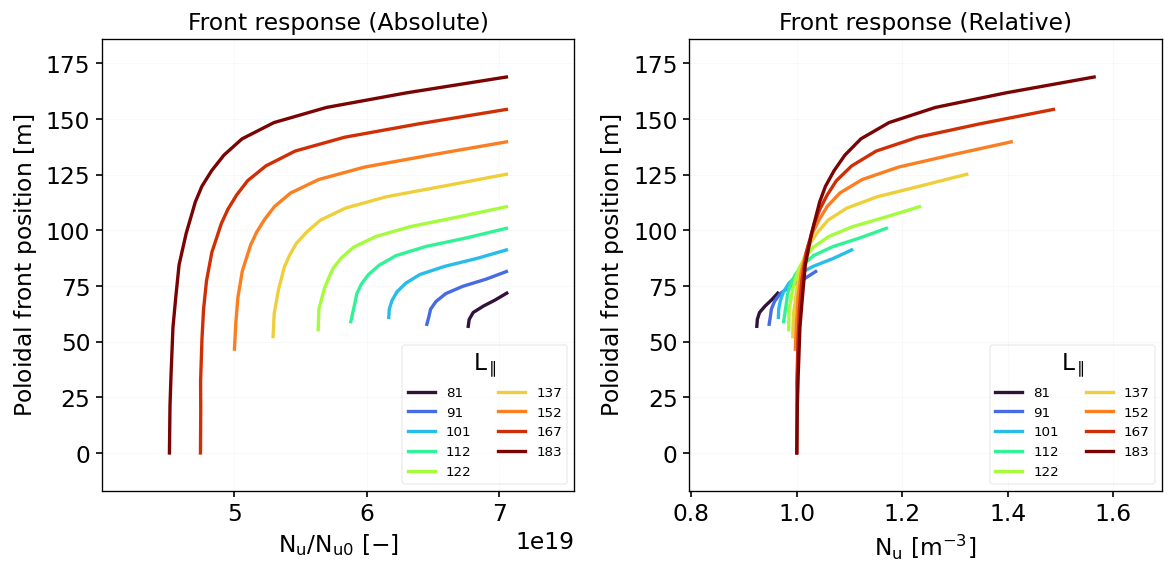

In [138]:
store = stores["inner_Lc"]
profiles = pstore["inner_Lc"]

fig, axes = plt.subplots(1,2, figsize = (10,5))
style = dict(lw = 2)

cmap = mpl.cm.get_cmap('turbo', 9)
colors = [cmap(x) for x in np.linspace(0,1, len(profiles))]

ax = axes[0]
for i, id in enumerate(profiles):
    s = store[id]
    ax.plot(s["cvar_trim"], s["SpolPlot"], label = f"{id:.0f}", color = colors[i], **style)
    
ax = axes[1]
for i, id in enumerate(profiles):
    s = store[id]
    ax.plot(s["crel_trim"], s["SpolPlot"], label = f"{id:.0f}", color = colors[i], **style)
    


axes[0].set_xlabel("$N_{u} / N_{u0}$ $[-]$")
axes[1].set_xlabel("$N_{u}$ $[m^{-3}]$")

for ax in axes.flatten():
    ax.set_ylabel("Poloidal front position $[m]$")
    ax.legend(fontsize = "xx-small", title = r"$L_{\parallel}$", loc = "lower right", ncols = 2)
    ax.margins(x=0.2)

axes[0].set_title("Front response (Absolute)")
axes[1].set_title("Front response (Relative)")
# store2.keys()
fig.tight_layout()

Text(0, 0.5, 'Relative change in window')

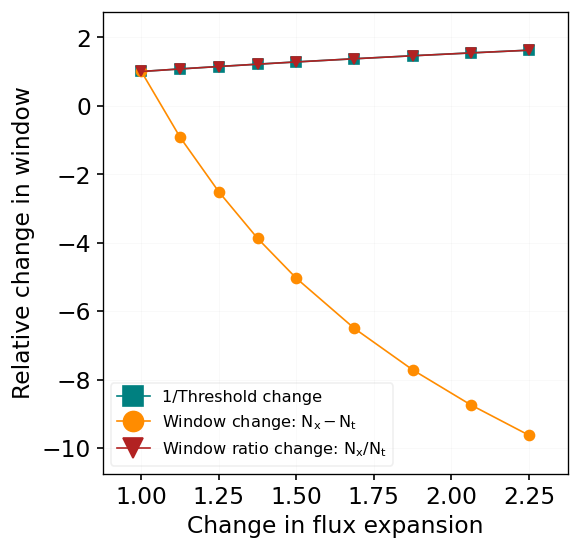

In [176]:
profiles, store = pstore["inner_Lc"], stores["inner_Lc"]

thresholds = np.array([store[x]["threshold"] for x in profiles])
window_ratios = np.array([store[x]["window_ratio"] for x in profiles])
windows = np.array([store[x]["window"] for x in profiles])


windows /= windows[0]
thresholds /= thresholds[0]
window_ratios /= window_ratios[0]
index = list(profiles.keys())
index /= index[0]


fig, ax = plt.subplots(figsize = (5,5))
ax.plot(index, 1/thresholds, label = "1/Threshold change", marker = "s", lw = 1)
ax.plot(index, windows, label = "Window change: $N_{x} - N_{t}$", marker = "o", lw = 1)
ax.plot(index, window_ratios, label = "Window ratio change: $N_{x} / N_{t}$", marker = "v", lw = 1)
ax.legend(fontsize = "x-small")
ax.set_xlabel("Change in flux expansion")
ax.set_ylabel("Relative change in window")

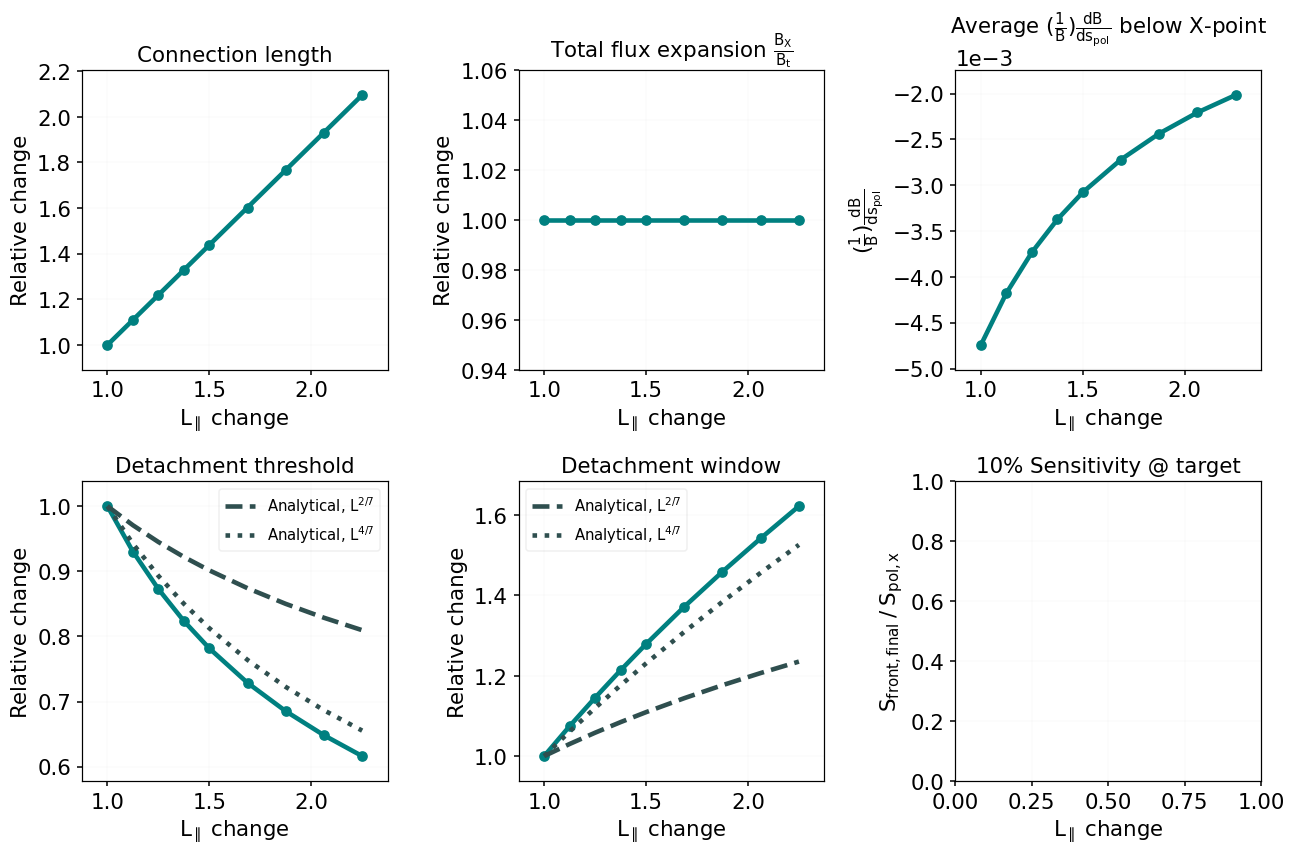

In [142]:
store = stores["inner_Lc"]
profiles = pstore["inner_Lc"]

plot_morph_results(profiles, store, xlabel = r"$L_{\parallel}$ change", show_47 = True, sens = False)

# Inner BxBt scan

In [227]:
stores = {}

C:\Users\mikek\AppData\Local\Temp\ipykernel_7520\1966015621.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Spectral_r', 9)


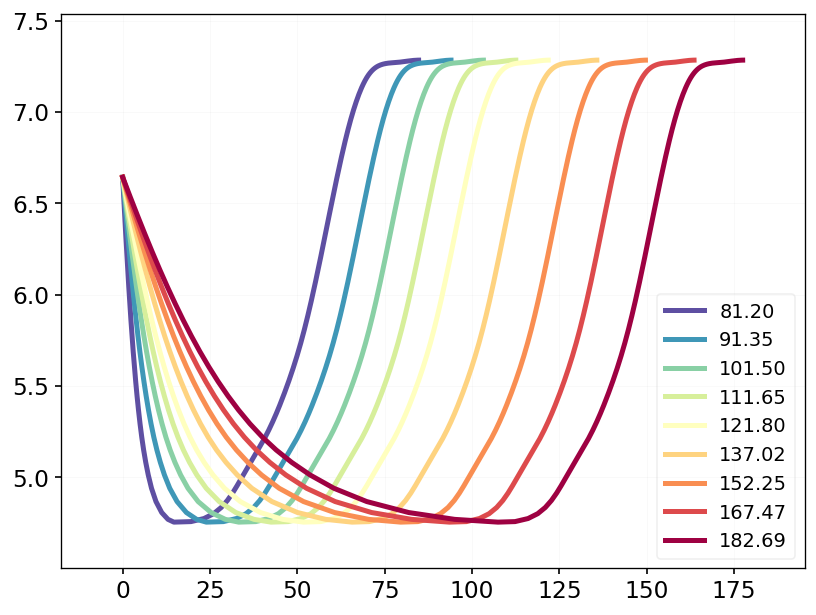

## Run

In [149]:
stores["inner_BxBt"] = dict()
profiles = pstore["inner_BxBt"]

# for i in [list(profiles.keys())[1]]:
for i in profiles:
    print(f"\n Profile: {i}")
    d = profiles[i].copy()
    fullrange = np.linspace(0, d["S"][d["Xpoint"]], 10) # Solve at these parallel positions
    
    # SparRange = [list(fullrange)[5]]
    SparRange = fullrange
    
    constants = constants_default.copy()
    if "i" in side:
        constants["qpllu0"] = 1.1e9

    results = LRBv21(constants, radios_default.copy(), 
                     d, 
                     SparRange, 
                     verbosity = 1, 
                     control_variable = "density", 
                     Ctol = 1e-3, Ttol=1e-3)
    
    stores["inner_BxBt"][i] = copy.deepcopy(results)


 Profile: 0.3578835827072183
Solving...0...6...11...15...18...20...21...22...23...24...Complete in 21.6 seconds

 Profile: 0.44735447838402287
Solving...0...6...11...15...18...20...21...22...23...24...Complete in 21.7 seconds

 Profile: 0.5368253740608275
Solving...0...6...11...15...18...20...21...22...23...24...Complete in 21.5 seconds

 Profile: 0.6262962697376321
Solving...0...6...11...15...18...20...21...22...23...24...Complete in 21.1 seconds

 Profile: 0.7157671654144366
Solving...0...6...11...15...18...20...21...22...23...24...Complete in 21.1 seconds

 Profile: 0.8947089567680457
Solving...0...6...11...15...18...20...21...22...23...24...Complete in 21.0 seconds

 Profile: 1.073650748121655
Solving...0...6...11...15...18...20...21...22...23...24...Complete in 21.2 seconds

 Profile: 1.2525925394752642
Solving...0...6...11...15...18...20...21...22...23...24...Complete in 21.5 seconds

 Profile: 1.4315343308288733
Solving...0...6...11...15...18...20...21...22...23...24...Complete

## Front traces

C:\Users\mikek\AppData\Local\Temp\ipykernel_7520\986905913.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('turbo', 9)


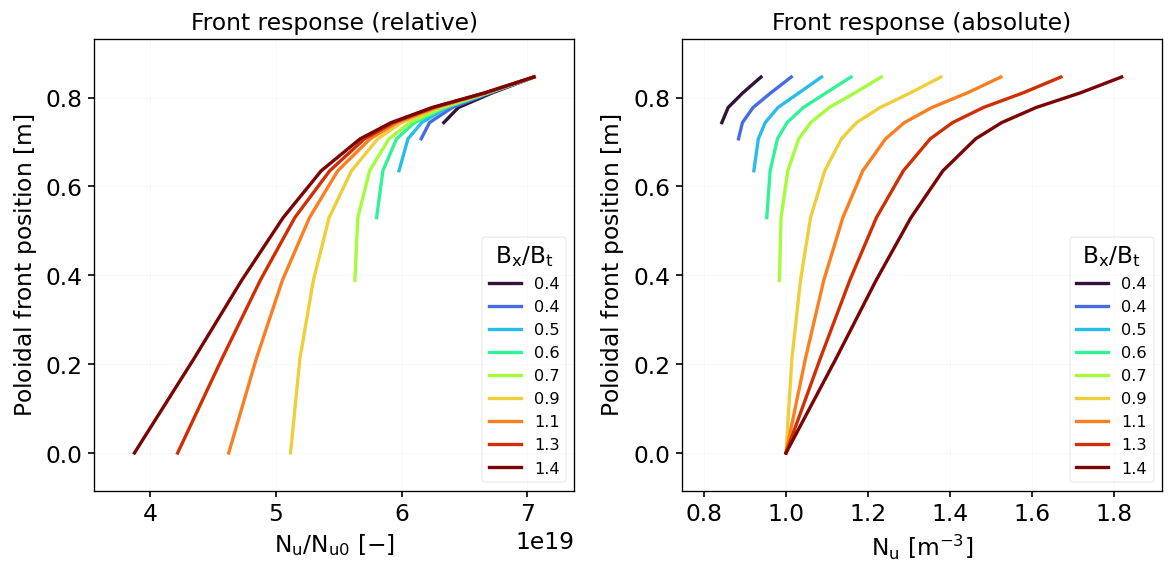

In [174]:
store = stores["inner_BxBt"]

fig, axes = plt.subplots(1,2, figsize = (10,5))
style = dict(lw = 2)

cmap = mpl.cm.get_cmap('turbo', 9)
colors = [cmap(x) for x in np.linspace(0,1, len(profiles))]

ax = axes[0]
for i, id in enumerate(profiles):
    s = store[id]
    ax.plot(s["cvar_trim"], s["SpolPlot"], label = f"{id:.1f}", color = colors[i], **style)
    
ax = axes[1]
for i, id in enumerate(profiles):
    s = store[id]
    ax.plot(s["crel_trim"], s["SpolPlot"], label = f"{id:.1f}", color = colors[i], **style)
    


axes[0].set_xlabel("$N_{u} / N_{u0}$ $[-]$")
axes[1].set_xlabel("$N_{u}$ $[m^{-3}]$")

for ax in axes.flatten():
    ax.set_ylabel("Poloidal front position $[m]$")
    ax.legend(fontsize = "x-small", title = "$B_{x} / B_{t}$", loc = "lower right")

axes[0].set_title("Front response (relative)")
axes[1].set_title("Front response (absolute)")
# store2.keys()
fig.tight_layout()

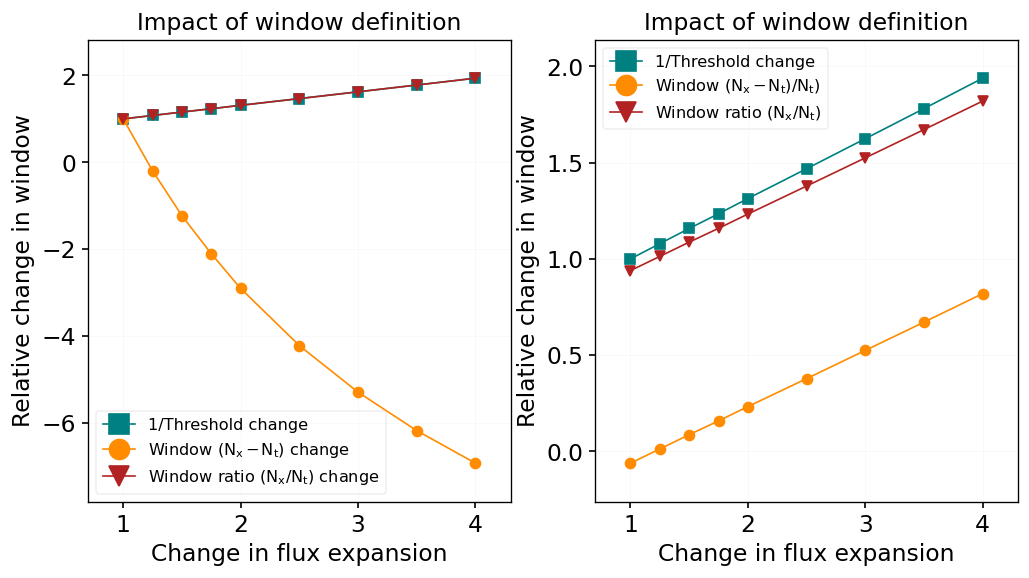

In [190]:
profiles, store = pstore["inner_BxBt"], stores["inner_BxBt"]

thresholds = np.array([store[x]["threshold"] for x in profiles])
window_ratios = np.array([store[x]["window_ratio"] for x in profiles])
windows = np.array([store[x]["window"] for x in profiles])
window_frac = windows / thresholds

# windows /= windows[0]
# thresholds /= thresholds[0]
# window_ratios /= window_ratios[0]
index = list(profiles.keys())
index /= index[0]


fig, axes = plt.subplots(1,2, figsize = (10,5))

ax = axes[0]
ax.plot(index, 1/(thresholds/thresholds[0]), label = "1/Threshold change", marker = "s", lw = 1)
ax.plot(index, windows/windows[0], label = "Window ($N_{x} - N_{t}$) change", marker = "o", lw = 1)
ax.plot(index, window_ratios/window_ratios[0], label = "Window ratio ($N_{x} / N_{t}$) change", marker = "v", lw = 1)
# ax.plot(index, window_ratios, label = "Window fraction: $N_{x} / N_{t}$", marker = "v", lw = 1)
ax.set_ylabel("Relative change in window")

ax = axes[1]
ax.plot(index, 1/(thresholds/thresholds[0]), label = "1/Threshold change", marker = "s", lw = 1)
ax.plot(index, windows/thresholds, label = "Window ($N_{x} - N_{t})/N_{t}$)", marker = "o", lw = 1)
ax.plot(index, window_ratios, label = "Window ratio ($N_{x} / N_{t}$)", marker = "v", lw = 1)
# ax.plot(index, window_ratios, label = "Window fraction: $N_{x} / N_{t}$", marker = "v", lw = 1)
ax.set_ylabel("Relative change in window")


for ax in axes:
    ax.legend(fontsize = "x-small")
    ax.set_xlabel("Change in flux expansion")
    
    ax.set_title("Impact of window definition")

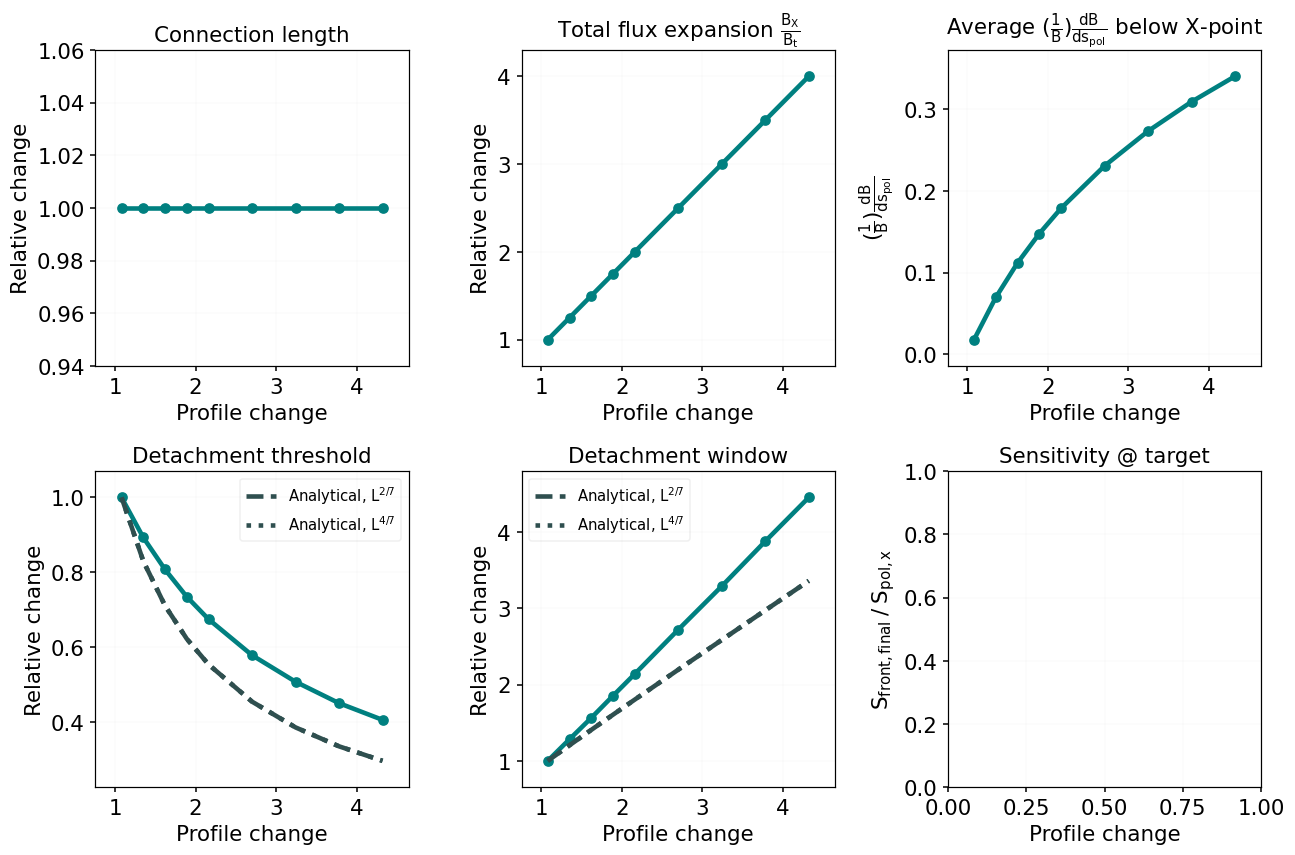

In [225]:
plot_morph_results(profiles, store)

# Outer BxBt scan

C:\Users\mikek\AppData\Local\Temp\ipykernel_7520\3678924865.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('turbo', 9)


Text(0.5, 1.0, 'Outer $B_{x} / B_{t}$ scan')

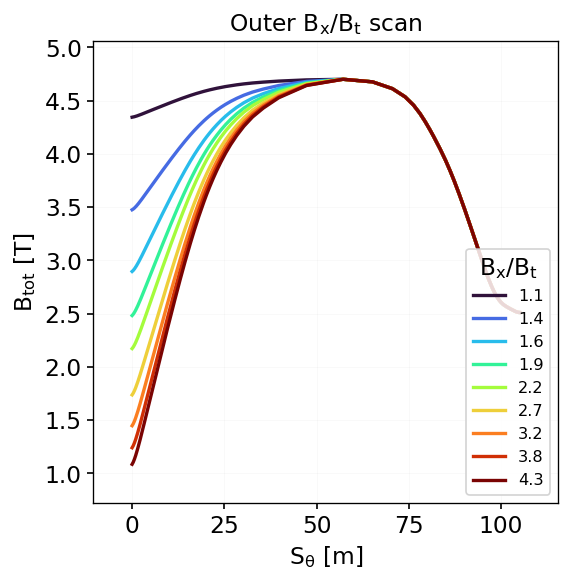

In [86]:
fig, ax = plt.subplots(figsize = (5,5))

cmap = mpl.cm.get_cmap('turbo', 9)
colors = [cmap(x) for x in np.linspace(0,1, len(profiles))]

name = "outer_BxBt"
for i, id in enumerate(pstore[name]):
    p = pstore[name][id]
    ax.plot(p.S, p.Btot, color = colors[i], label = f"{id:.1f}", lw = 2)
    # print(id, p.get_connection_length())
    
ax.legend(fontsize = "x-small", title = r"$B_{x} / B_{t}$", loc = "lower right", framealpha = 0.85)
ax.set_xlabel(r"$S_{{\theta}}$ $[m]$")
ax.set_ylabel("$B_{tot}$ $[T]$")
ax.set_title(r"Outer $B_{x} / B_{t}$ scan")

## Run

In [150]:
stores["outer_BxBt"] = dict()
profiles = pstore["outer_BxBt"]

# for i in [list(profiles.keys())[1]]:
for i in profiles:
    print(f"\n Profile: {i:.3f}")
    d = profiles[i].copy()
    fullrange = np.linspace(0, d["S"][d["Xpoint"]], 10) # Solve at these parallel positions
    
    # SparRange = [list(fullrange)[5]]
    SparRange = fullrange
    
    constants = constants_default.copy()
    if "i" in side:
        constants["qpllu0"] = 1.1e9
    if "o" in side:
        constants["qpllu0"] = 2.0e9

    results = LRBv21(constants, radios_default.copy(), 
                     d, 
                     SparRange, 
                     verbosity = 1, 
                     control_variable = "density", 
                     Ctol = 1e-3, Ttol=1e-3)
    
    stores["outer_BxBt"][i] = copy.deepcopy(results)


 Profile: 1.082
Solving...0...28...48...60...67...71...73...74...75...Complete in 19.0 seconds

 Profile: 1.352
Solving...0...28...48...60...67...71...73...74...75...Complete in 19.4 seconds

 Profile: 1.623
Solving...0...28...48...60...67...71...73...74...75...Complete in 18.6 seconds

 Profile: 1.893
Solving...0...28...48...60...67...71...73...74...75...Complete in 19.3 seconds

 Profile: 2.164
Solving...0...28...48...60...67...71...73...74...75...Complete in 19.4 seconds

 Profile: 2.705
Solving...0...28...48...60...67...71...73...74...75...Complete in 18.8 seconds

 Profile: 3.246
Solving...0...28...48...60...67...71...73...74...75...Complete in 18.2 seconds

 Profile: 3.787
Solving...0...28...48...60...67...71...73...74...75...Complete in 18.5 seconds

 Profile: 4.328
Solving...0...28...48...60...67...71...73...74...75...Complete in 18.4 seconds


## Front traces

C:\Users\mikek\AppData\Local\Temp\ipykernel_7520\629013162.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('turbo', 9)


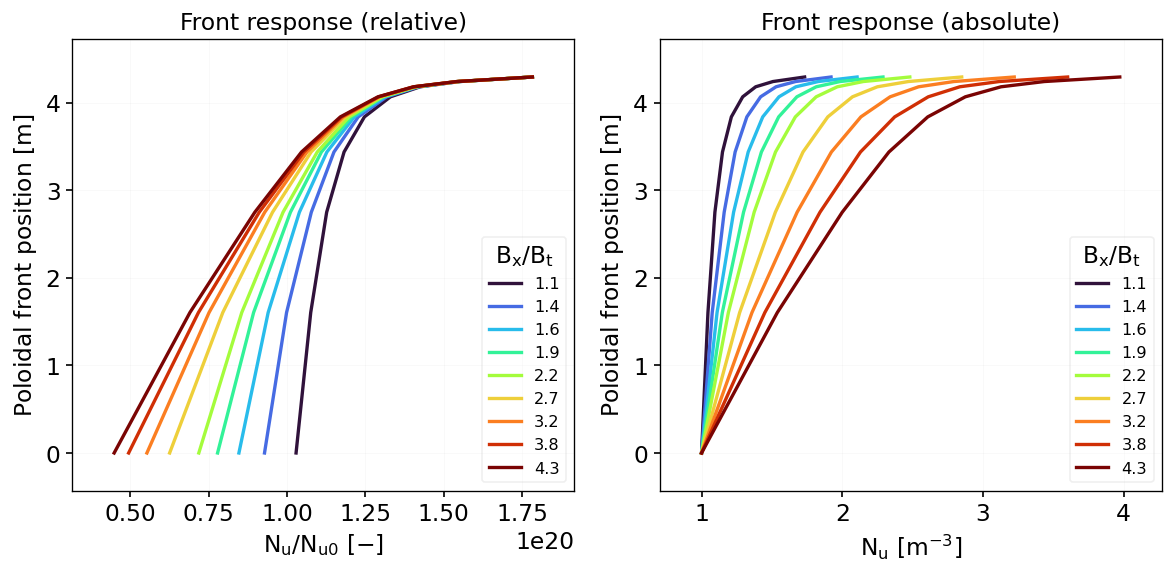

In [76]:
store = stores["outer_BxBt"]

fig, axes = plt.subplots(1,2, figsize = (10,5))
style = dict(lw = 2)

cmap = mpl.cm.get_cmap('turbo', 9)
colors = [cmap(x) for x in np.linspace(0,1, len(profiles))]

ax = axes[0]
for i, id in enumerate(profiles):
    s = store[id]
    ax.plot(s["cvar_trim"], s["SpolPlot"], label = f"{id:.1f}", color = colors[i], **style)
    
ax = axes[1]
for i, id in enumerate(profiles):
    s = store[id]
    ax.plot(s["crel_trim"], s["SpolPlot"], label = f"{id:.1f}", color = colors[i], **style)
    


axes[0].set_xlabel("$N_{u} / N_{u0}$ $[-]$")
axes[1].set_xlabel("$N_{u}$ $[m^{-3}]$")

for ax in axes.flatten():
    ax.set_ylabel("Poloidal front position $[m]$")
    ax.legend(fontsize = "x-small", title = "$B_{x} / B_{t}$", loc = "lower right")

axes[0].set_title("Front response (relative)")
axes[1].set_title("Front response (absolute)")
# store2.keys()
fig.tight_layout()

In [93]:
np.array([get_sensitivity(store[x]["crel_trim"], store[x]["SpolPlot"], fluctuation=1.05, location=0.0) for x in profiles])

array([0.40402296, 0.26424904, 0.18778226, 0.14183729, 0.10857253,
       0.07717475, 0.05739693, 0.04550345, 0.03788244])

Text(0.5, 1.0, 'Impact of window definition')

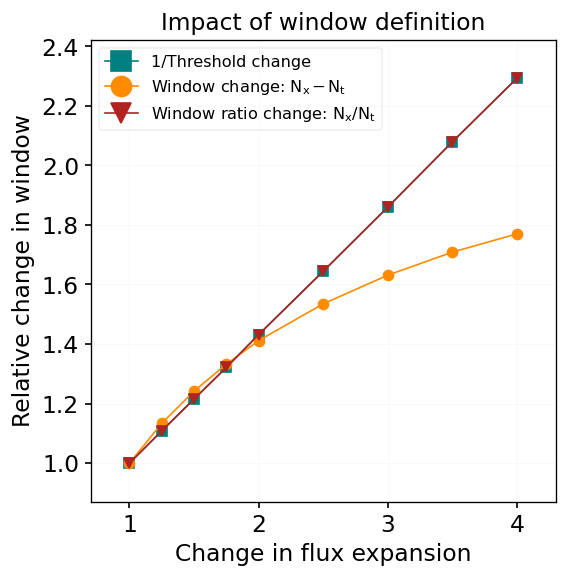

In [175]:
profiles, store = pstore["outer_BxBt"], stores["outer_BxBt"]

thresholds = np.array([store[x]["threshold"] for x in profiles])
window_ratios = np.array([store[x]["window_ratio"] for x in profiles])
windows = np.array([store[x]["window"] for x in profiles])


windows /= windows[0]
thresholds /= thresholds[0]
window_ratios /= window_ratios[0]
index = list(pstore["outer_BxBt"].keys())
index /= index[0]


fig, ax = plt.subplots(figsize = (5,5))
ax.plot(index, 1/thresholds, label = "1/Threshold change", marker = "s", lw = 1)
ax.plot(index, windows, label = "Window change: $N_{x} - N_{t}$", marker = "o", lw = 1)
ax.plot(index, window_ratios, label = "Window ratio change: $N_{x} / N_{t}$", marker = "v", lw = 1)
ax.legend(fontsize = "x-small")
ax.set_xlabel("Change in flux expansion")
ax.set_ylabel("Relative change in window")
ax.set_title("Impact of window definition")

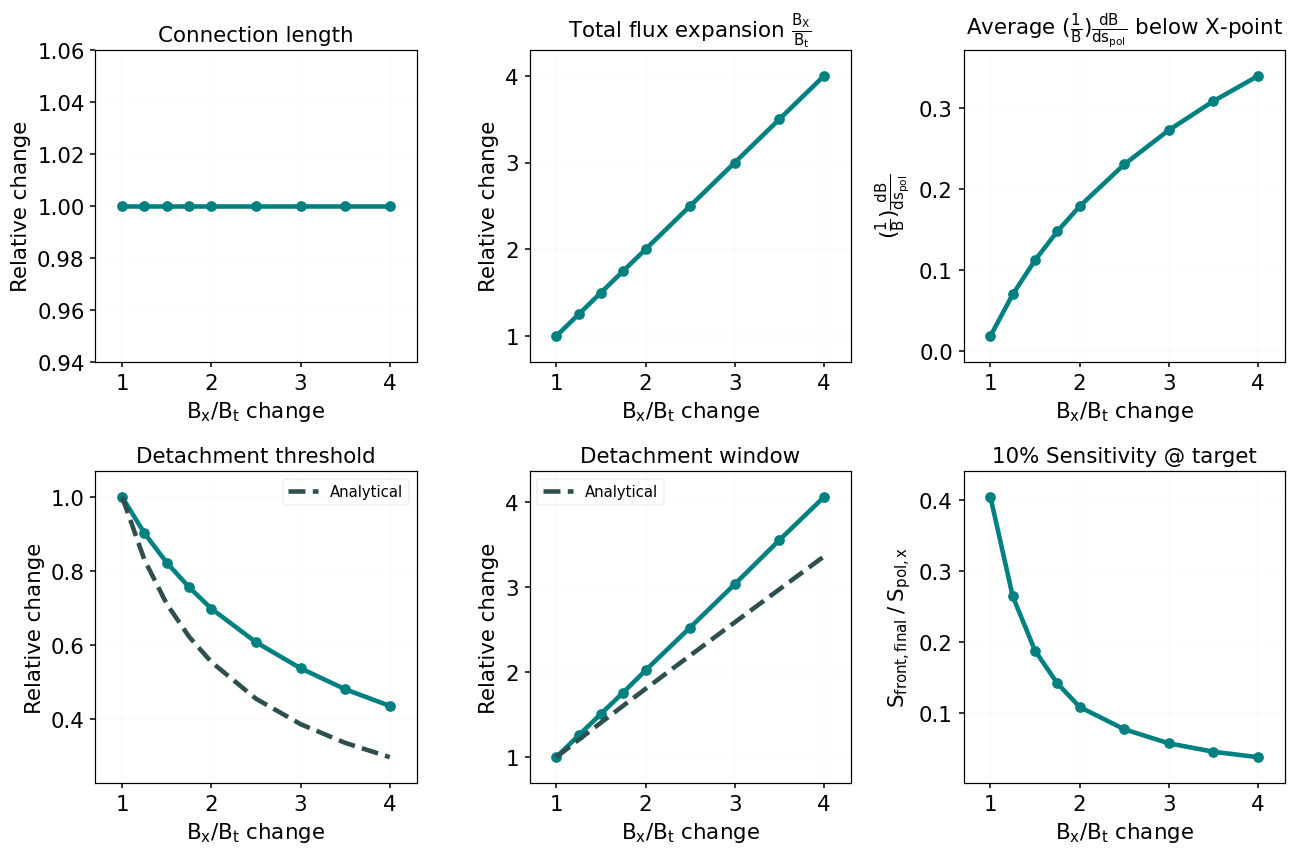

In [115]:
plot_morph_results(pstore["outer_BxBt"], stores["outer_BxBt"], xlabel = "$B_{x} / B_{t}$ change", show_47 = False)

# Outer Lc scan

C:\Users\mikek\AppData\Local\Temp\ipykernel_7520\2353593658.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('turbo', 9)


Text(0.5, 1.0, 'Outer $L_{\\parallel}$ scan')

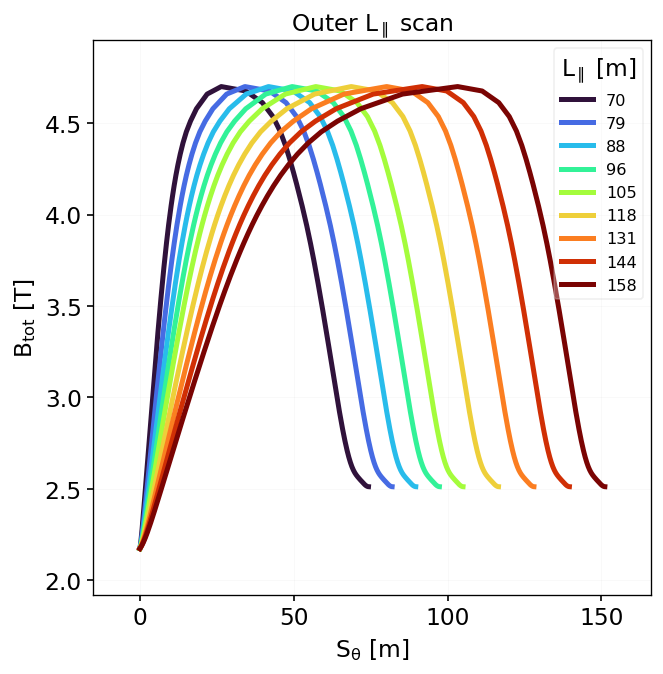

In [98]:
fig, ax = plt.subplots(figsize = (6,6))

cmap = mpl.cm.get_cmap('turbo', 9)
colors = [cmap(x) for x in np.linspace(0,1, len(profiles))]

name = "outer_Lc"
for i, id in enumerate(pstore[name]):
    p = pstore[name][id]
    ax.plot(p.S, p.Btot, color = colors[i], label = f"{id:.0f}")
    # print(id, p.get_connection_length())
    
ax.legend(fontsize = "x-small", title = r"$L_{\parallel}$ $[m]$", loc = "best")
ax.set_xlabel(r"$S_{{\theta}}$ $[m]$")
ax.set_ylabel("$B_{tot}$ $[T]$")
ax.set_title(r"Outer $L_{\parallel}$ scan")

## Run

In [151]:
stores["outer_Lc"] = dict()
profiles = pstore["outer_Lc"]

# for i in [list(profiles.keys())[1]]:
for i in profiles:
    print(f"\n Profile: {i:.3f}")
    d = profiles[i].copy()
    fullrange = np.linspace(0, d["S"][d["Xpoint"]], 10) # Solve at these parallel positions
    
    # SparRange = [list(fullrange)[5]]
    SparRange = fullrange
    
    constants = constants_default.copy()
    if "i" in side:
        constants["qpllu0"] = 1.1e9
    if "o" in side:
        constants["qpllu0"] = 2.0e9

    results = LRBv21(constants, radios_default.copy(), 
                     d, 
                     SparRange, 
                     verbosity = 1, 
                     control_variable = "density", 
                     Ctol = 1e-3, Ttol=1e-3)
    
    stores["outer_Lc"][i] = copy.deepcopy(results)


 Profile: 70.010
Solving...0...28...48...60...67...71...73...74...75...Complete in 17.2 seconds

 Profile: 78.761
Solving...0...28...48...60...67...71...73...74...75...Complete in 18.3 seconds

 Profile: 87.512
Solving...0...28...48...60...67...71...73...74...75...Complete in 19.1 seconds

 Profile: 96.264
Solving...0...28...48...60...67...71...73...74...75...Complete in 17.4 seconds

 Profile: 105.015
Solving...0...28...48...60...67...71...73...74...75...Complete in 18.4 seconds

 Profile: 118.142
Solving...0...28...48...60...67...71...73...74...75...Complete in 17.9 seconds

 Profile: 131.269
75...Complete in 22.0 seconds

 Profile: 144.395
Solving...0...28...48...60...67...71...73...74...75...Complete in 18.4 seconds

 Profile: 157.522
75...Complete in 22.8 seconds


## Front traces

C:\Users\mikek\AppData\Local\Temp\ipykernel_7520\2899338810.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('turbo', 9)


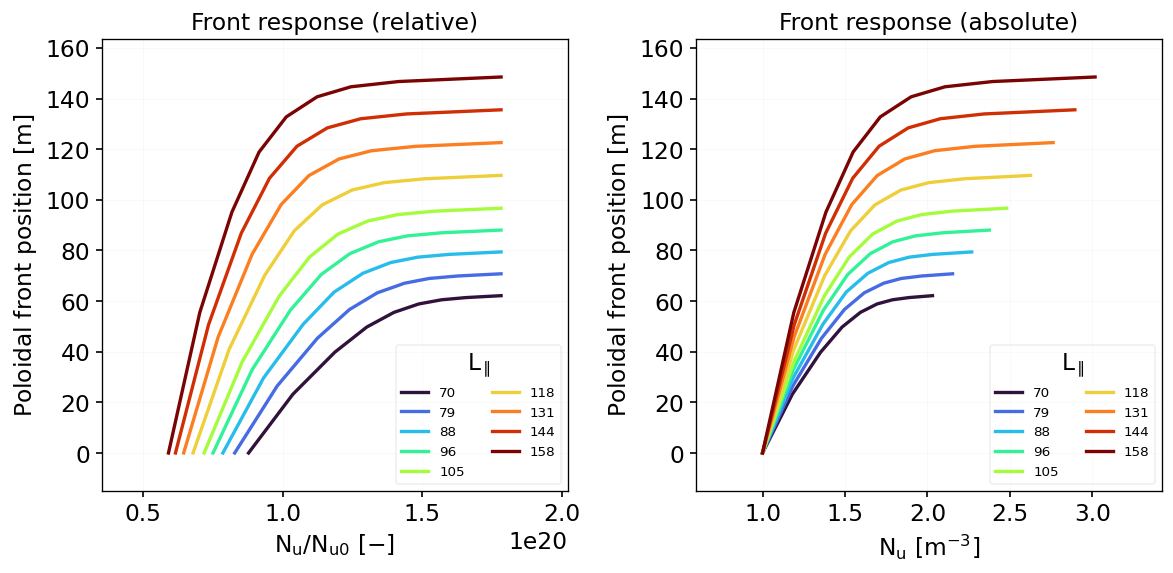

In [108]:
store = stores["outer_Lc"]

fig, axes = plt.subplots(1,2, figsize = (10,5))
style = dict(lw = 2)

cmap = mpl.cm.get_cmap('turbo', 9)
colors = [cmap(x) for x in np.linspace(0,1, len(profiles))]

ax = axes[0]
for i, id in enumerate(profiles):
    s = store[id]
    ax.plot(s["cvar_trim"], s["SpolPlot"], label = f"{id:.0f}", color = colors[i], **style)
    
ax = axes[1]
for i, id in enumerate(profiles):
    s = store[id]
    ax.plot(s["crel_trim"], s["SpolPlot"], label = f"{id:.0f}", color = colors[i], **style)
    


axes[0].set_xlabel("$N_{u} / N_{u0}$ $[-]$")
axes[1].set_xlabel("$N_{u}$ $[m^{-3}]$")

for ax in axes.flatten():
    ax.set_ylabel("Poloidal front position $[m]$")
    ax.legend(fontsize = "xx-small", title = r"$L_{\parallel}$", loc = "lower right", ncols = 2)
    ax.margins(x=0.2)

axes[0].set_title("Front response (relative)")
axes[1].set_title("Front response (absolute)")
# store2.keys()
fig.tight_layout()

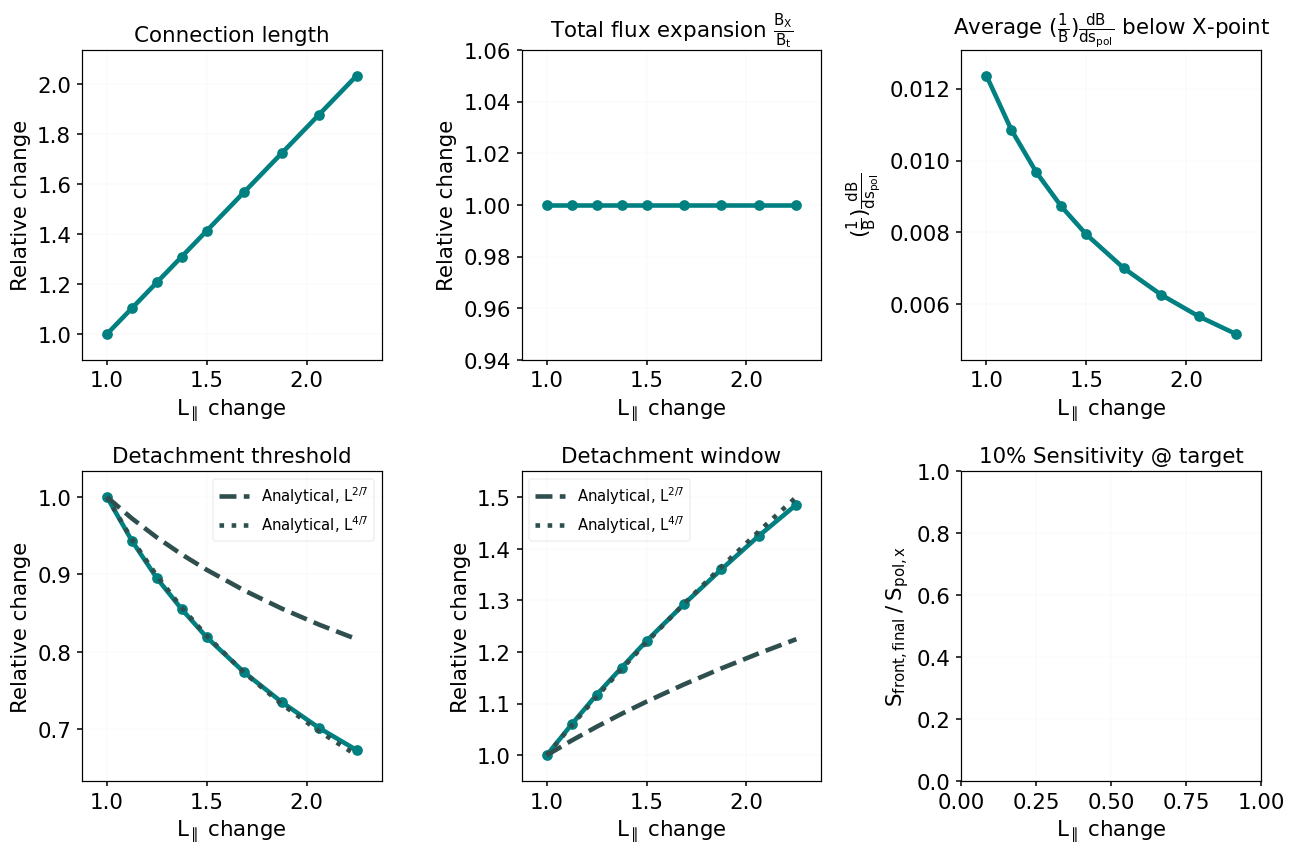

In [193]:
store, profiles = stores["outer_Lc"], pstore["outer_Lc"]
plot_morph_results(profiles, store, xlabel = r"$L_{\parallel}$ change", show_47 = True, sens = False)